# Bank Marketing
In this notebook, the goal is to create a propensity model, which is essentially a classification model.
This model aims to detect whether the client will subscribe to the marketing campaign or not.  
  
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.  
  
This dataset is based on "Bank Marketing" UCI dataset (please check the description at: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).  
  
The binary classification goal is to predict if the client will subscribe a bank term deposit (variable y).

### Input variables:
| Column | Type | Description |
|---|---|---|
| age | numeric | client age |
| job | categorical | type of job ("admin.", "blue-collar", ..., "unemployed", "unknown")|
| marital | categorical | marital status ("divorced", "married", "single", "unknown"; note: "divorced" means divorced or widowed) |
| education | categorical | level of education ("basic.4y", "basic.6y", "basic.9y", "high.school", "illiterate", "professional.course", "university.degree", "unknown") |
| default | categorical | has credit in default? ("no", "yes", "unknown") |
| housing | categorical | has housing loan? ("no", "yes", "unknown")   |
| loan | categorical | has personal loan?("no", "yes", "unknown") |
| contact | categorical | contact communication type ("cellular", "telephone") |
| month | categorical | last contact month of year ("jan", "feb", "mar", ..., "nov", "dec")   |
| day_of_week | categorical | last contact day of the week ("mon", "tue", "wed", "thu", "fri")  |
| duration | numeric | last contact duration in seconds. Important note: this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model |
| campaign | numeric | number of contacts performed during this campaign and for this client |
| pdays | numeric | number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted) |
| previous | numeric | number of contacts performed before this campaign and for this client |
| poutcome | categorical | outcome of the previous marketing campaign ("failure", "nonexistent", "success") |
| emp.var.rate | numeric | employment variation rate - quarterly indicator |
| cons.price.idx | numeric | consumer price index - monthly indicator |
| cons.conf.idx | numeric | consumer confidence index - monthly indicator  |
| euribor3m | numeric | euribor 3 month rate - daily indicator |
| nr.employed | numeric | number of employees - quarterly indicator |
| y (target) | binary | has the client subscribed a term deposit? ("yes", "no") |
  
OBS: Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques.

# 0. Import libraries

In [77]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from helper_functions.plots import make_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, auc, classification_report, roc_curve
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from xgboost import XGBClassifier

# 1. Loading Data

In [2]:
dataset_path = "../datasets/bank_marketing/bank-additional/bank-additional-full.csv"
df = pd.read_csv(dataset_path, sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


OBS: The column duration will not be used (check the input variables table)  
  
We will work with the following numeric columns:

In [3]:
numeric_columns = [
    "age",
    "campaign",
    "pdays",
    "previous",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed",
]
df[numeric_columns].head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0


And with the following categorical columns:

In [4]:
categorical_columns = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "poutcome",
]
df[categorical_columns].head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent


# 2. EDA (Exploratory Data Analysis)

In this dataset, missing data was replaced with unknown. To visualize it, we will substitute unknown with np.nan and use the missingno library to get a visual representation of the missing values in our dataset.

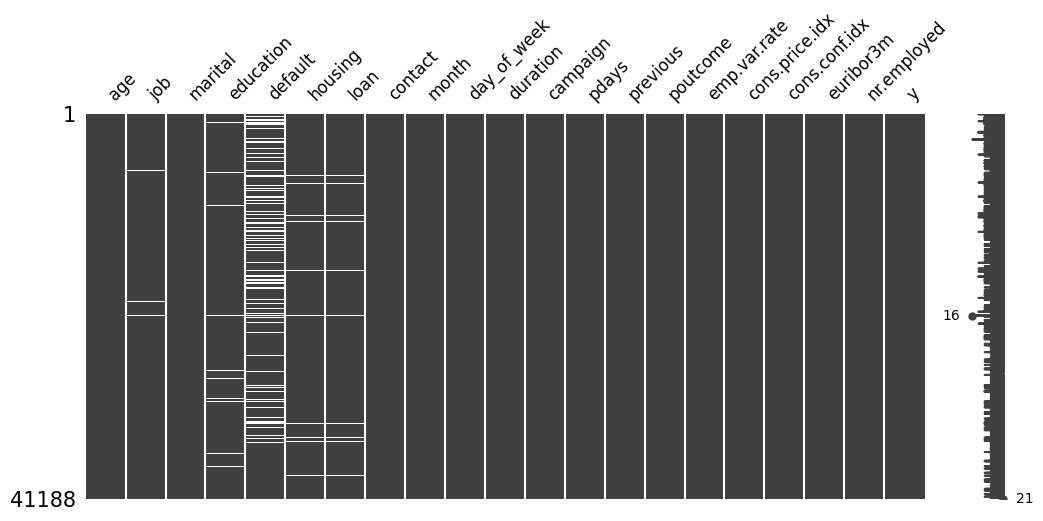

In [5]:
msno.matrix(df.replace("unknown", np.nan), figsize=(12, 5), fontsize=12)
plt.show()

Keeping the data as unknown can be useful, as the indication that this information is missing can be a relevant pattern.

In [6]:
df[numeric_columns].describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Next, we will plot the distribution of the categories of the categorical columns and the target in a bar chart.

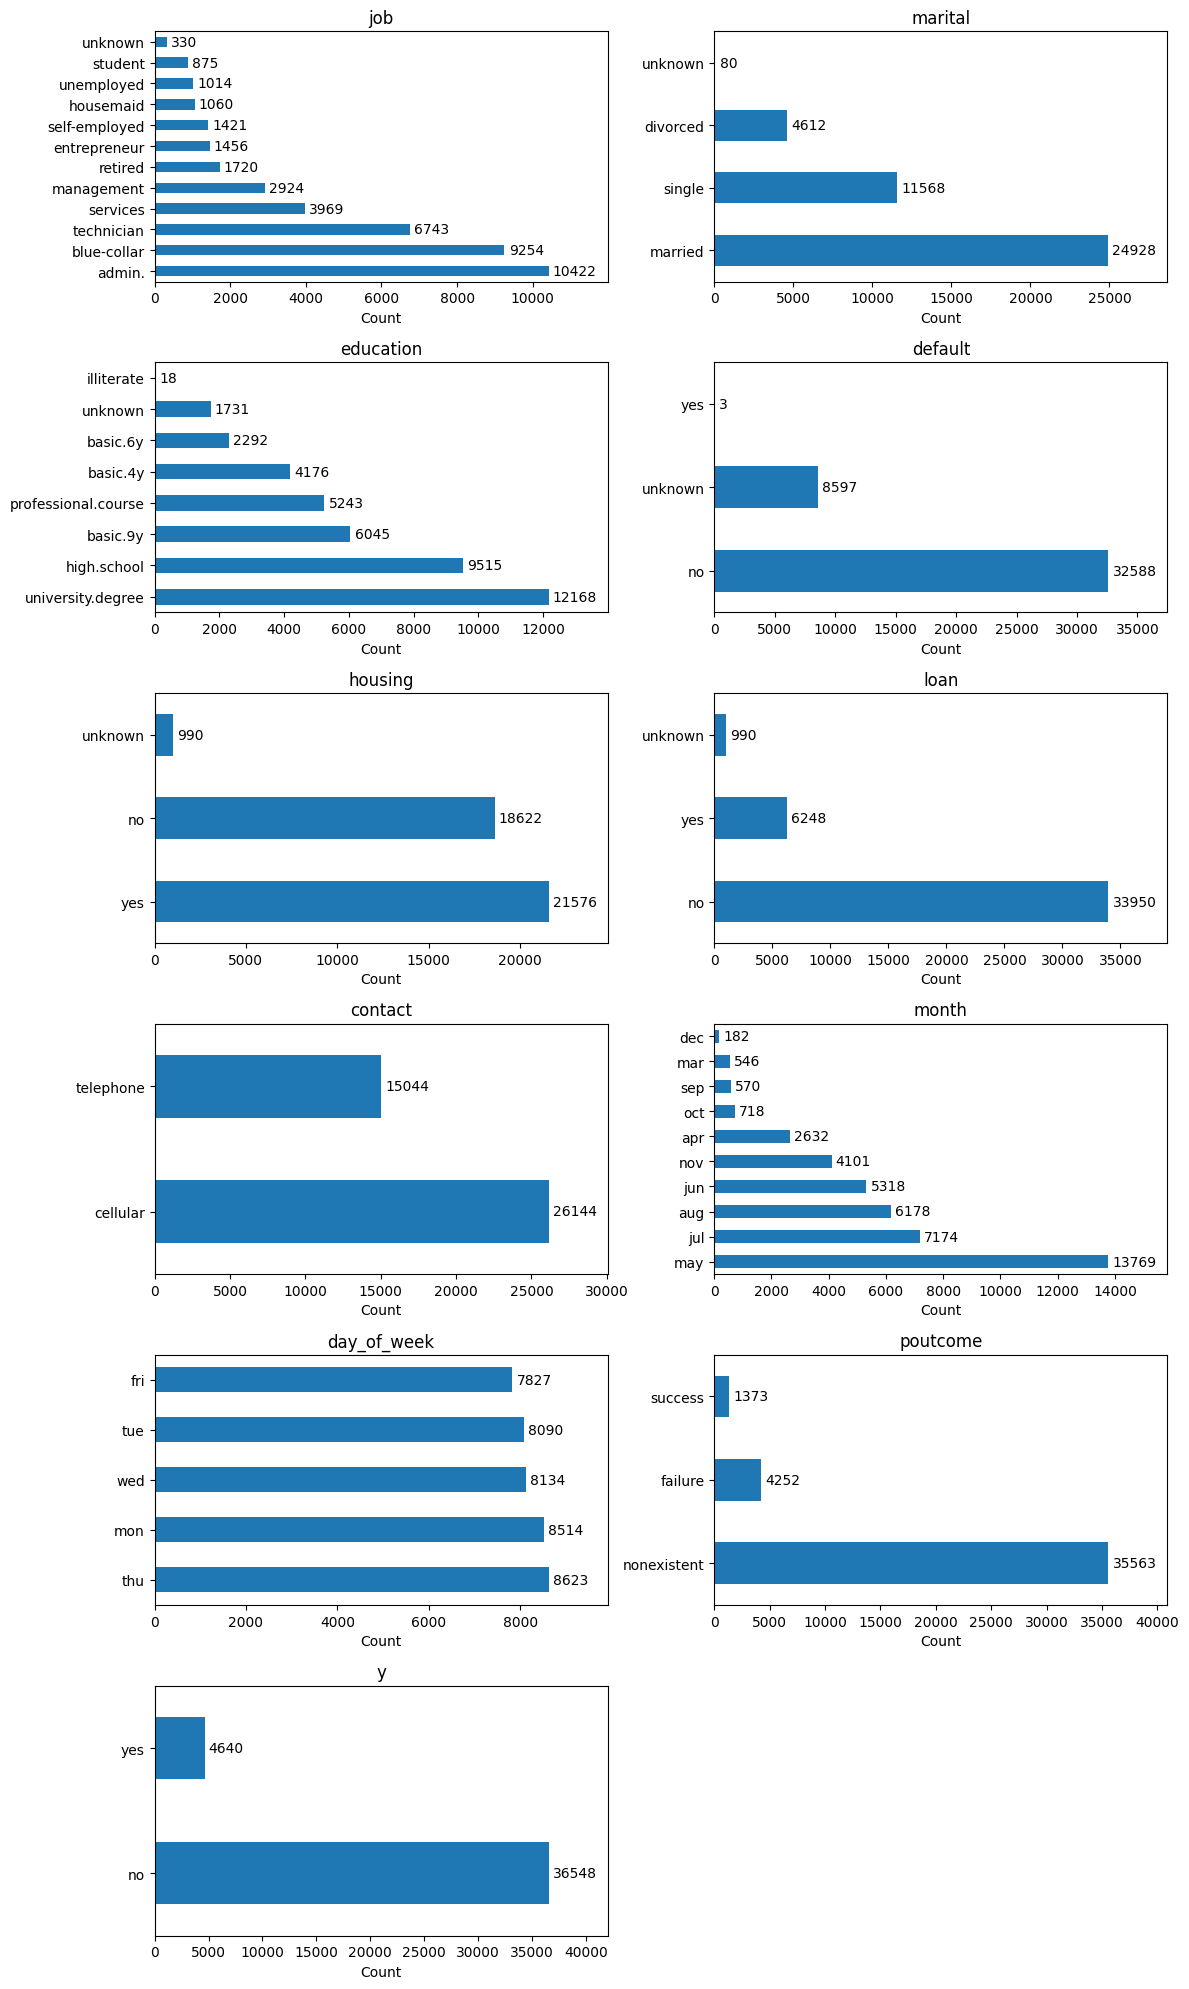

In [7]:
columns = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "poutcome",
    "y",
]

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(12, 20))
axes = axes.flatten()

for idx, col in enumerate(columns):
    ax = axes[idx]
    df[col].value_counts(dropna=False).plot(kind="barh", ax=ax)
    ax.set_title(col)
    ax.set_xlabel("Count")
    ax.set_ylabel("")

    for container in ax.containers:
        ax.bar_label(container, fmt="%d", label_type="edge", padding=3)

    max_count = df[col].value_counts(dropna=False).max()
    ax.set_xlim(right=max_count * 1.15)

for j in range(len(columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

As we can see, the y (target) variable is quite unbalanced.

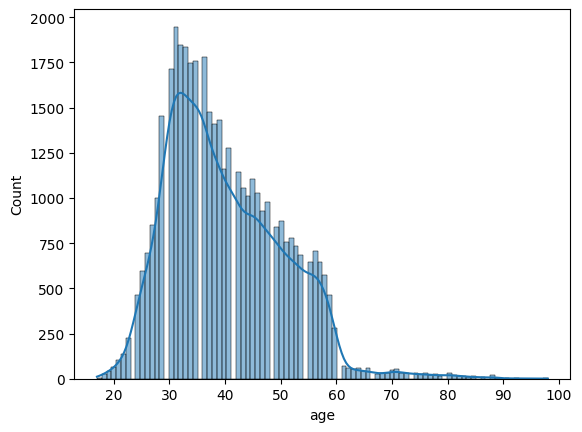

In [8]:
sns.histplot(data=df, x="age", kde=True)
plt.show()

# 3. Preprocessing

In [9]:
def encoder_categorical(df: pd.DataFrame, categorical_columns: list[str]) -> np.ndarray:
    ohe_model = OneHotEncoder()
    result = ohe_model.fit_transform(df[categorical_columns])

    return result.toarray(), ohe_model


def encoder_numeric(df: pd.DataFrame, numeric_columns: list[str]) -> np.ndarray:
    return df[numeric_columns].to_numpy()


def encoder_df(df: pd.DataFrame, categorical_columns: list[str], numeric_columns: list[str]) -> np.ndarray:
    ohe_array, _ = encoder_categorical(df, categorical_columns)
    nc_array = encoder_numeric(df, numeric_columns)

    encoded_array = np.concatenate((ohe_array, nc_array), axis=1)

    return encoded_array

In [10]:
encoded_df = encoder_df(df.reset_index(drop=True), categorical_columns, numeric_columns)
print(encoded_df.shape)

(41188, 62)


In [11]:
encoded_df

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ..., -3.6400e+01,
         4.8570e+00,  5.1910e+03],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ..., -3.6400e+01,
         4.8570e+00,  5.1910e+03],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ..., -3.6400e+01,
         4.8570e+00,  5.1910e+03],
       ...,
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ..., -5.0800e+01,
         1.0280e+00,  4.9636e+03],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ..., -5.0800e+01,
         1.0280e+00,  4.9636e+03],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ..., -5.0800e+01,
         1.0280e+00,  4.9636e+03]], shape=(41188, 62))

In [12]:
X = encoded_df

mapping = {"no": 0, "yes": 1}
y = df["y"].map(mapping).to_numpy()

X.shape, y.shape

((41188, 62), (41188,))

# 4. Train and Evaluate models

To train and evaluate classification models, we use a set of essential metrics that help us understand the model's performance and generalization capability. The basis for calculating these metrics are the following definitions:

- TP (True Positive): The model predicted the positive class, and the class is indeed positive. This represents the correct hits for the class of interest.
- TN (True Negative): The model predicted the negative class, and the class is indeed negative. This represents the correct hits for the class opposite to the one of interest.
- FP (False Positive): The model predicted the positive class, but the class is actually negative. Also known as Type I error, this is when the model "cries wolf."
- FN (False Negative): The model predicted the negative class, but the class is actually positive. Also known as Type II error, this is when the model "misses" a positive case.

#### Accuracy
Accuracy measures the proportion of correct predictions relative to the total number of predictions. It's an intuitive metric but can be misleading in cases of imbalanced classes.
$$
acc = \frac{TP + TN}{TP + TN + FP + FN}
$$

#### Precision
Precision focuses on cases predicted as positive. It answers the question: "Of all that were identified as positive, how many were actually positive?" It's crucial when the cost of a False Positive is high.
$$
precision = \frac{TP}{TP + FP}
$$

#### Recall (Sensitivity)
Recall, also known as Sensitivity, focuses on cases that are actually positive. It answers the question: "Of all that were truly positive, how many were correctly identified by the model?" It's vital when the cost of a False Negative is high.
$$
recall = \frac{TP}{TP + FN}
$$

#### F1 Score
The F1 Score is the harmonic mean of Precision and Recall. It seeks a balance between these two metrics, being particularly useful when there's an imbalance between Precision and Recall or when a single metric that considers both is desired.
$$
F1 Score = \frac{2 * (Precision * Recall)}{(Precision + Recall)}
$$

#### AUC Score
AUC (Area Under the Curve) is a comprehensive metric that evaluates the model's ability to distinguish between classes. It's calculated from the ROC Curve (Receiver Operating Characteristic), which plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at different classification thresholds. AUC ranges from 0 to 1, where 1 indicates a perfect model in separating classes and 0.5 indicates a random model with no discriminatory power. An AUC closer to 1 generally indicates a model with better overall performance.

#### ROC Curve
The ROC Curve (Receiver Operating Characteristic) is a graphical plot that illustrates the trade-off between the True Positive Rate (TPR - the proportion of correctly identified positives) and the False Positive Rate (FPR - the proportion of incorrectly identified negatives as positives) for various classification thresholds. By analyzing the ROC curve, we can visually understand the model's ability to distinguish between classes at different cut-off points and compare the performance of multiple models. An ideal model would have an ROC curve that quickly rises towards the top-left corner of the graph.

#### Confusion Matrix
The Confusion Matrix is a fundamental and visual tool for analyzing the performance of a classification model. It organizes the model's predictions into a table that compares the predicted values with the actual class values. The matrix contains four main values: True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN). Through the confusion matrix, it's possible to identify not only the number of correct and incorrect predictions but also the specific types of errors the model is making, helping to identify issues such as imbalanced classes, model bias, or difficulties in classifying certain categories.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7, stratify=y)

num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=7)

In [14]:
models = [
    ("KNN", KNeighborsClassifier()),
    ("RFC", RandomForestClassifier()),
    ("XGB", XGBClassifier()),
    ("CART", DecisionTreeClassifier()),
    ("NB", GaussianNB()),
    ("SVM", SVC()),
]

metrics = list()
results = list()
names = list()

for name, model in (pbar := tqdm(models)):
    pbar.set_description(name)

    scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)

    results.append(cv_results)
    names.append(name)
    metrics.append({
        "name": name,
        "auc": cv_results["test_roc_auc"].mean(),
        "accuracy": cv_results["test_accuracy"].mean(),
        "precision": cv_results["test_precision"].mean(),
        "recall": cv_results["test_recall"].mean(),
        "f1": cv_results["test_f1"].mean(),
    })

pd.DataFrame(metrics).sort_values(by="auc", ascending=False)

SVM: 100%|██████████| 6/6 [02:47<00:00, 27.98s/it] 


,name,auc,accuracy,precision,recall,f1
2,XGB,0.786976,0.897420,0.590633,0.290404,0.389160
1,RFC,0.777048,0.892989,0.546540,0.293380,0.381636
4,NB,0.767867,0.855478,0.384883,0.471977,0.423874
0,KNN,0.734412,0.888680,0.510523,0.289060,0.368881
5,SVM,0.703437,0.897269,0.635398,0.209585,0.314610
3,CART,0.621815,0.840030,0.307201,0.333778,0.319840


# 5. XGBClassifier

From now on, we will work with the XGBClassifier model. First, we will train the model and plot its ROC curve and its confusion matrix.

In [31]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

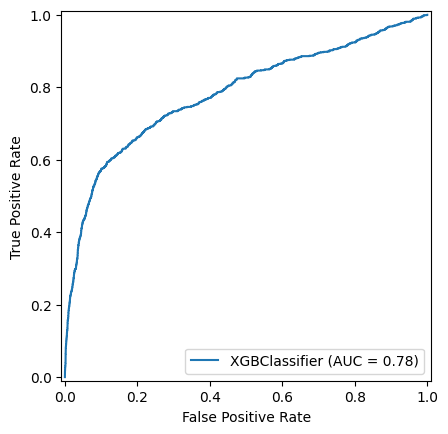

In [32]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, name="XGBClassifier")
display.plot()
plt.show()

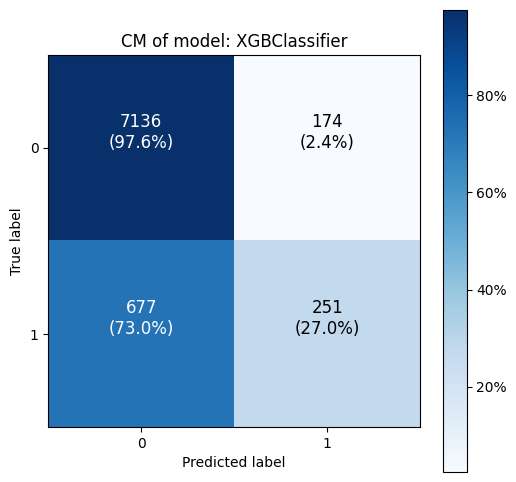

In [38]:
make_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    figsize=(6, 6),
    text_size=12,
    title="CM of model: XGBClassifier",
)

### 5.1 Scale Pos Weight

By setting `scale_pos_weight` to the ratio of the number of negative instances to the number of positive instances, the model gives more weight to the minority class during training.

The intuition for `scale_pos_weight` is that it tells you how many negative instances (labeled as "0") there are for each positive instance (labeled as "1") in your dataset.

It can be set as follows (as recommended in the library documentation):

$$
scale\_pos\_weight = \frac{Number\:of\:Positive\:Class\:Instances}{Number\:of\:Negative\:Class\:Instances}
$$

For a stickiness model, we want to give more importance to customers who have joined the campaign, so that we can find customers with similar profiles and thus target the marketing campaign to these potential customers.

In [44]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

model = XGBClassifier(scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

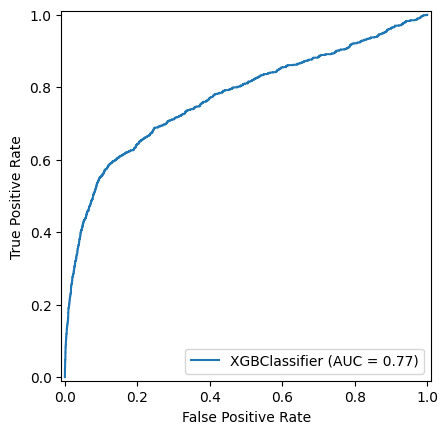

In [45]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, name="XGBClassifier")
display.plot()
plt.show()

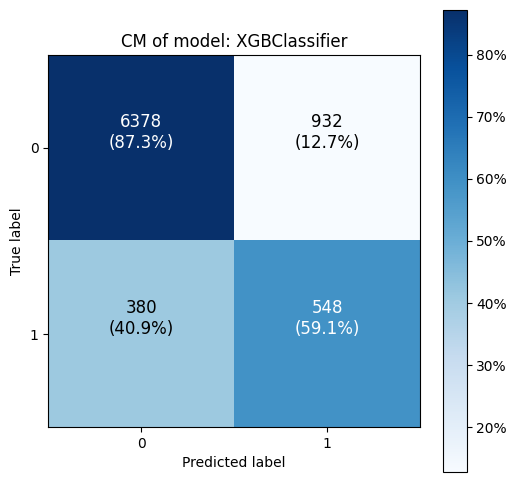

In [46]:
make_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    figsize=(6, 6),
    text_size=12,
    title="CM of model: XGBClassifier",
)

### 5.2 Grid Search

In [49]:
param_grid = {
    "min_child_weight": [1, 5, 10],
    "gamma": [0.5, 1, 1.5, 2, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "max_depth": [3, 4, 5],
}

In [50]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

model = XGBClassifier(scale_pos_weight=scale_pos_weight)

In [53]:
CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.6, 0.8, ...], 'gamma': [0.5, 1, ...], 'max_depth': [3, 4, ...], 'min_child_weight': [1, 5, ...], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [54]:
CV_rfc.best_params_

{'colsample_bytree': 1.0,
 'gamma': 5,
 'max_depth': 5,
 'min_child_weight': 10,
 'subsample': 1.0}

Fit with best params

In [66]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    min_child_weight=CV_rfc.best_params_["min_child_weight"],
    gamma=CV_rfc.best_params_["gamma"],
    subsample=CV_rfc.best_params_["subsample"],
    colsample_bytree=CV_rfc.best_params_["colsample_bytree"],
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

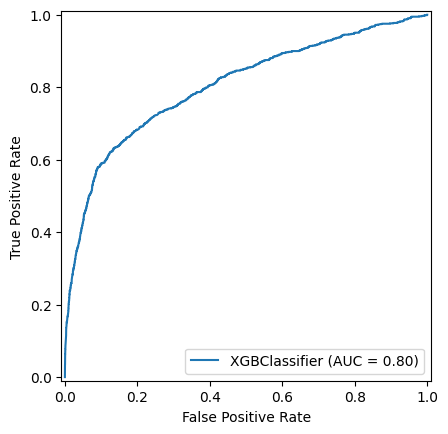

In [67]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, name="XGBClassifier")
display.plot()
plt.show()

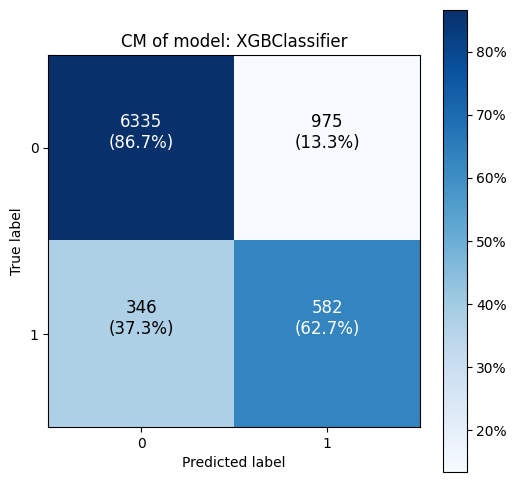

In [68]:
make_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    figsize=(6, 6),
    text_size=12,
    title="CM of model: XGBClassifier",
)

In [69]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      7310
           1       0.37      0.63      0.47       928

    accuracy                           0.84      8238
   macro avg       0.66      0.75      0.69      8238
weighted avg       0.88      0.84      0.86      8238

